##### Tutorial on making the plot Interactive #####
https://saturncloud.io/blog/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/#:~:text=To%20make%20our%203D%20plot,using%20our%20mouse%20or%20trackpad. 

In [10]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib inline
# I didn't have the line "%matplotlib inline" and then the plots weren't showing 

# What's really important is %matplotlib widget cause that's how I was able to make it interactive

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import functools
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize
import math
import numpy.matlib as npm
import cv2

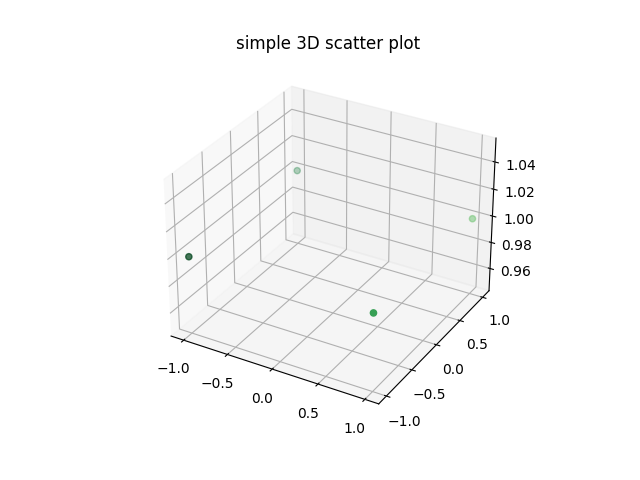

In [12]:
# Creating dataset
square = np.array([[1, 1, 1], [1, -1, 1], [-1, 1, 1], [-1, -1, 1]])

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
 
# Create a gradient for the colorsx
num_points = square.shape[0]
gradient = np.linspace(0.5, 1, num_points)
colors = plt.cm.Greens(gradient)

# Creating plot
ax.scatter(square[:, 0], square[:, 1], square[:, 2], c=colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

(2500, 3)
(2500, 3)


C:\Users\Joshua\AppData\Local\Temp\ipykernel_96044\214452720.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
C:\Users\Joshua\AppData\Local\Temp\ipykernel_96044\214452720.py:68: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(points_3D_new[:,0], points_3D_new[:,1], points_3D_new[:,2], c=color_new, cmap=custom_cmap, s=50, marker='o')


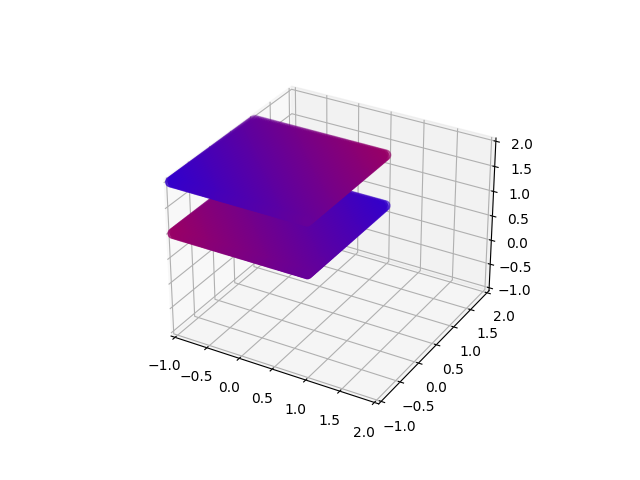

In [47]:
# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
cmap_colors_transformation = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
num_points = 50
lowest_color_value = 0.2
highest_color_value = 0.8
z_value = 1.
x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
X_color, Y_color = np.meshgrid(x_color, y_color)

# Combine data for both dimensions into a single variable
combined_data = X_color + Y_color  # You can use a different combination as needed

# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)

# Make sure the color is in the right form (num of data points x 4), so we have a 
# color for each datapoint
color_new = color.reshape((-1, 4))
color_new_transformation = np.copy(color_new)

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the boundaries of the square we are creating
min_x = -1
max_x = 1

min_y = -1
max_y = 1

z_value = 1
z_value_transformation = 2

# Create a grid of x and y values that will be the points of our "plane"
x_grid = np.linspace(min_x, max_x, num_points)
y_grid = np.linspace(min_y, max_y, num_points)

# Use np.meshgrid and reshaping to make this into a collection of points 
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid = X_grid.reshape((-1, 1))
Y_grid = Y_grid.reshape((-1, 1))
Z_grid = np.full(X_grid.shape, z_value)

points_3D_original = np.concatenate((X_grid, Y_grid, Z_grid), axis=1)

# Create a different z value to distinguish original and transformed matrix
Z_grid_2s = np.full(Z_grid.shape, z_value_transformation)

# Create transformed matrix
points_3D_new = points_3D_original[:,:2]

points_3D_new = np.concatenate((points_3D_new, Z_grid_2s), axis=1)

rotation_matrix = np.array([[0, -1, 0], [-1, 0, 0], [0, 0, 1]])
points_3D_rotate = np.matmul(points_3D_new, rotation_matrix)
print(points_3D_original.shape)
points_3D_new = points_3D_rotate
print(points_3D_new.shape)
# Plot the 3D grid with the colormap representing both dimensions for both the original and the transformed matrix
ax.scatter(X_grid, Y_grid, Z_grid, c=color_new, cmap=custom_cmap, s=50, marker='o')
ax.scatter(points_3D_new[:,0], points_3D_new[:,1], points_3D_new[:,2], c=color_new, cmap=custom_cmap, s=50, marker='o')

# Set the 3D axis limits so we can view everything
min_val = min(points_3D_new.flatten())
max_val = max(points_3D_new.flatten())

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_zlim(min_val, max_val)

# Show the plot
plt.show()

##### Creating 2D version of the homographies by getting rid of one dimension ##### 

points_3D_original.shape (2500, 3)
0.9999999999999999
[[ 1.68199836 -0.3313537   2.        ]
 [ 1.7313537   1.08199836  2.        ]
 [ 0.5         0.2         1.        ]]


C:\Users\Joshua\AppData\Local\Temp\ipykernel_96044\2092572719.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tensor[:,0], tensor[:,1], tensor[:,2], c=color_new, cmap=custom_cmap, s=50, marker='o')


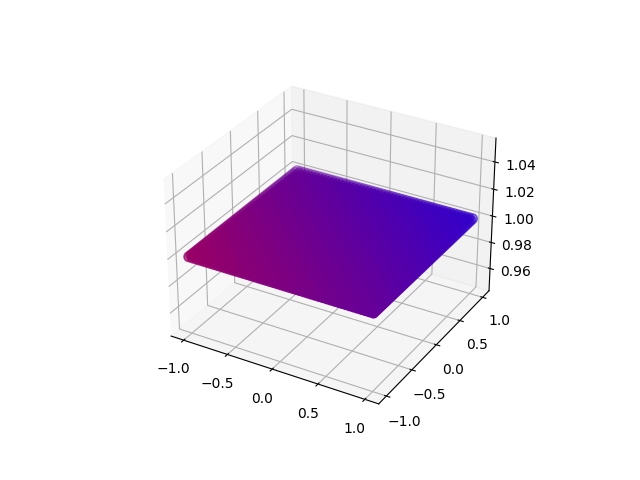

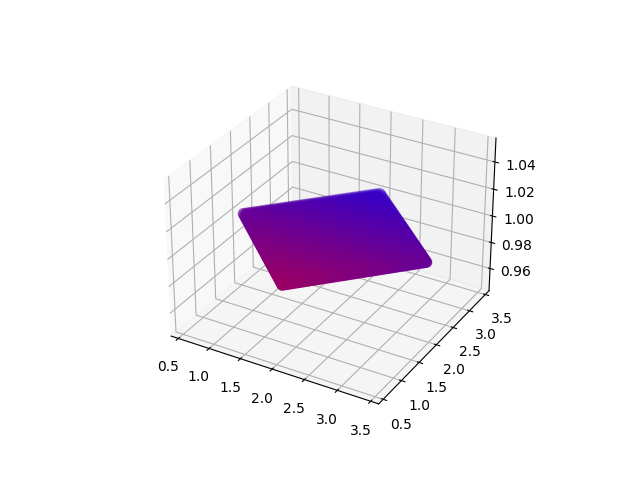

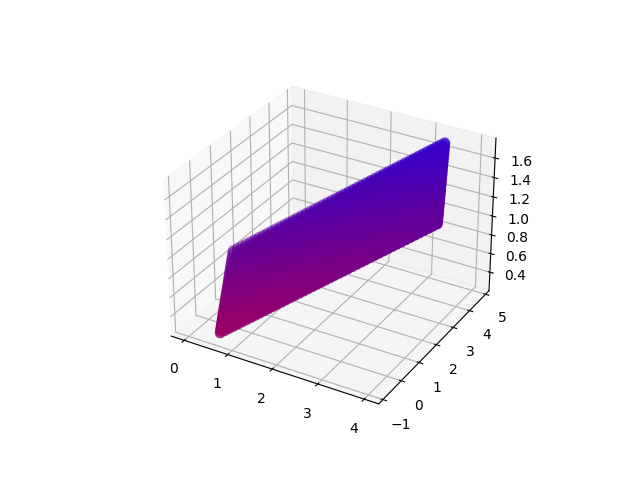

C:\Users\Joshua\AppData\Local\Temp\ipykernel_96044\2092572719.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tensor[:,0], tensor[:,1], c=color_new, cmap=custom_cmap, s=50, marker='o')


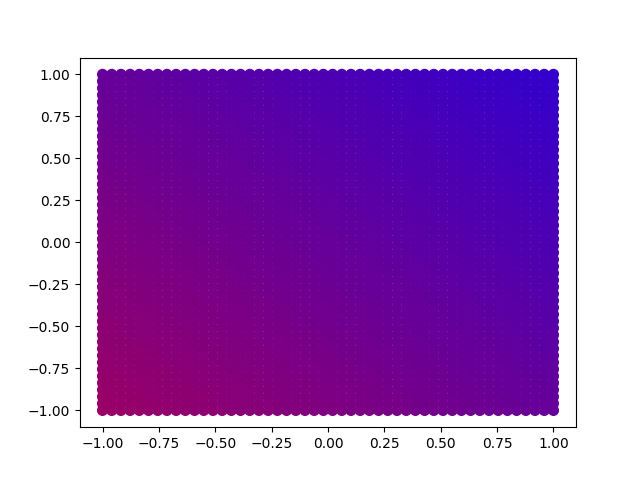

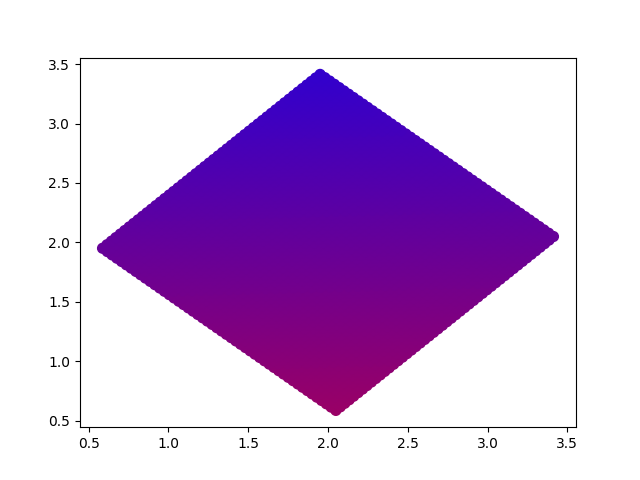

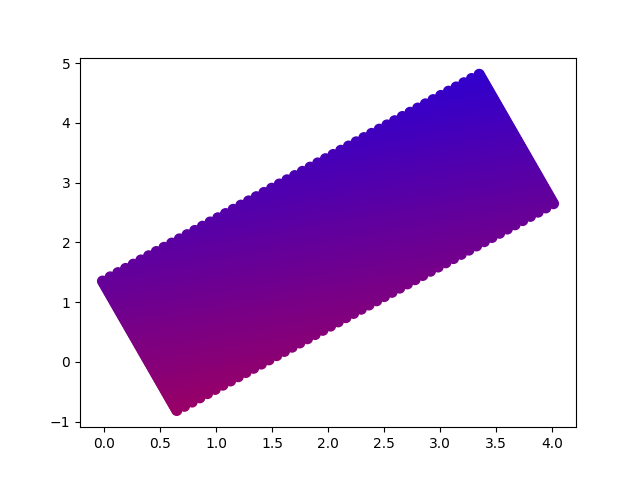

In [83]:
def get_rid_of_z_dimension(array_3D):
    """
    Description:
    This function makes an array with x,y,z values and gets rid of the z values in all dimensinos
    Params:
    array_3D, a 3D array of the form Nx3
    Return, a 2D array of the form Nx2
    """
    return np.delete(array_3D, -1, axis=-1)

def plot_tensor(tensor):
    """
    Description:
    This functions plots an array with x,y,z and x,y values.
    Params:
    array, a 3D or 2D array of the form Nx3 and Nx2 respectively
    Return
    None
    """
    custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

    num_points = int(math.sqrt(tensor.shape[0]))
    lowest_color_value = 0.2
    highest_color_value = 0.8
    x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
    y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
    X_color, Y_color = np.meshgrid(x_color, y_color)

    # Combine data for both dimensions into a single variable
    combined_data = X_color + Y_color  # You can use a different combination as needed

    # Apply the custom colormap to the combined data
    color = custom_cmap(combined_data)

    # Make sure the color is in the right form (num of data points x 4), so we have a 
    # color for each datapoint
    color_new = color.reshape((-1, 4))
    
    if len(tensor.shape) == 2:
        if tensor.shape[-1] == 3:
            # Combine data for both dimensions into a single variable
            combined_data = X_color + Y_color  # You can use a different combination as needed

            # Apply the custom colormap to the combined data
            color = custom_cmap(combined_data)

            # Make sure the color is in the right form (num of data points x 4), so we have a 
            # color for each datapoint
            color_new = color.reshape((-1, 4))
            
            # Create a figure and axis
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(tensor[:,0], tensor[:,1], tensor[:,2], c=color_new, cmap=custom_cmap, s=50, marker='o')
            # # Set the 3D axis limits so we can view everything
            # min_val = min(tensor.flatten())
            # max_val = max(tensor.flatten())

            # ax.set_xlim(min_val, max_val)
            # ax.set_ylim(min_val, max_val)
            # ax.set_zlim(min_val, max_val)
            plt.show()
        elif tensor.shape[-1] == 2:
            # Create a figure and axis
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(tensor[:,0], tensor[:,1], c=color_new, cmap=custom_cmap, s=50, marker='o')
            # # Set the 3D axis limits so we can view everything
            # min_val = min(tensor.flatten())
            # max_val = max(tensor.flatten())

            # ax.set_xlim(min_val, max_val)
            # ax.set_ylim(min_val, max_val)
            plt.show()
    return

def create_rotation_matrix_clockwise(degrees):
    "Descript: creates and returns a rotation matrix that rotates degrees counter-clockwise around the origin" 
    radians = math.radians(degrees)

    cos_theta = math.cos(radians)
    sin_theta = math.sin(radians)

    # 2D rotation matrix
    rotation_matrix = np.array([[cos_theta, -sin_theta, 0],
                                [sin_theta, cos_theta, 0],
                                [0, 0, 1]])

    return rotation_matrix

def create_translation_matrix(dx, dy, dz = 0, dims = 2):
    "Descript: creates and returns a translation matrix that translates by dx and dy"

    if dims == 2:
        translation_matrix = np.array([[1, 0, dx], 
                                       [0, 1, dy], 
                                       [0, 0, 1]])
    elif dims == 3:
        translation_matrix = np.array([[1, 0, 0, dx],
                                       [0, 1, 0, dy],
                                       [0, 0, 1, dz], 
                                       [0, 0, 0, 1]])

    return translation_matrix

def create_scale_matrix(scaleX, scaleY, dims = 2):
    "Descript: creates and returns a scale matrix that scales by scale"
    scale_matrix = np.array([[scaleX, 0, 0],
                             [0, scaleY, 0],
                             [0, 0, 1]])

    return scale_matrix

def create_skew_matrix(skew_amt, dims = 2):
    "Descript: creates and returns a skew matrix that based on skew amt"

    # Horizontal Skew
    radians = math.radians(skew_amt)
    skew_matrix_X = np.array([[1, skew_amt, 0],
                            [0, 1, 0],
                            [0, 0, 1]])
    
    skew_matrix_Y = np.array([[1, 0, 0],
                              [skew_amt, 1, 0],
                              [0, 0, 1]])
    
    return skew_matrix_X, skew_matrix_Y

def create_warp_matrix(warp_x, warp_y, dims=2):
    """ Description: Creates and returns a matrix that only """
    warp_matrix = np.array([[1, 0 , 0], 
                             [0, 1, 0],
                             [warp_x, warp_y, 1]])
    return warp_matrix


def apply_transformation(tensor, transformation):
    """
    Description: Applies a 3x3 homography to an Nx3 tensor and returns an Nx3 tensor
    """
    # print("transformation.shape: ", transformation.shape)
    # print("tensor.shape: ", tensor.shape)
    # print()
    return np.matmul(transformation, tensor.T).T

def create_affine_transformation():
    """
    Description: Creates a 3x3 affine transformation by appling a rotation matrix, translation matrix, scaling matrix, and skew matrix 
    You will have to change the input to these functions to create your final affine transformation matrix. 
    """
    rotation_matrix = create_rotation_matrix_clockwise(47)
    translation_matrix = create_translation_matrix(2, 2)
    scaling_matrix = create_scale_matrix(1, 1)
    skew_matrix_X, skew_matrix_Y = create_skew_matrix(0)
    
    # print(np.matmul(rotation_matrix, translation_matrix))

    # print("Rotation matrix")
    # print(rotation_matrix)
    # print("Translation matrix")
    # print(translation_matrix)
    # print("scaling matrix")
    # print(scaling_matrix)
    # print("skew matrices")
    # print(skew_matrix_X)
    # print(skew_matrix_Y)

    # print(rotation_matrix.shape)
    # print(translation_matrix.shape)
    # print(scaling_matrix.shape)
    # print(skew_matrix_X.shape)
    # print(skew_matrix_Y.shape)

    affine_transformation = functools.reduce(np.matmul, [translation_matrix, skew_matrix_X, scaling_matrix, rotation_matrix])
    # affine_transformation = translation_matrix * skew_matrix_X * skew_matrix_Y * scaling_matrix * rotation_matrix

    return affine_transformation

def create_homography_transformation():
    """
    Description: Creates a 3x3 homography by appling a rotation matrix, translation matrix, scaling matrix, skew matrix, and a warping. 
    You will have to change the input to these functions to create your final affine transformation matrix. 
    """
    rotation_matrix = create_rotation_matrix_clockwise(47)
    translation_matrix = create_translation_matrix(2, 2)
    scaling_matrix = create_scale_matrix(1, 1)
    skew_matrix_X, skew_matrix_Y = create_skew_matrix(0)
    warp_matrix = create_warp_matrix(0.5, 0.2)

    homography = functools.reduce(np.matmul, [translation_matrix, skew_matrix_X, scaling_matrix, rotation_matrix, warp_matrix])

    return homography

points_2D_original = get_rid_of_z_dimension(points_3D_original)
affine_transformation = create_affine_transformation()
homography = create_homography_transformation()
points_3D_affine = apply_transformation(points_3D_original, affine_transformation)
print("points_3D_original.shape", points_3D_original.shape)
points_3D_homography = apply_transformation(points_3D_original, homography)
homography_determinant = np.linalg.det(homography)
print(homography_determinant)

# print("points_3D_original")
# print(points_3D_original[0,:])
# print("points_3D_transformed")
# print(points_3D_affine[0,:])
points_2D_affine = get_rid_of_z_dimension(points_3D_affine)
points_2D_homography = get_rid_of_z_dimension(points_3D_homography)
# print("Affine transformation shape: ", affine_transformation.shape)
print(homography)

plot_tensor(points_3D_original)
plot_tensor(points_3D_affine)
plot_tensor(points_3D_homography)

plot_tensor(points_2D_original)
plot_tensor(points_2D_affine)
plot_tensor(points_2D_homography)


    

In [84]:
DEFAULT_HOMOGENOUS_COORDINATE = 1
SCATTER_DOT_SIZE = 5

def get_homogenous_img_coordinates(img):
    (width, height) = img.shape
    X, Y = np.mgrid[0:width, 0:height]
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
    homogenous_coordinates = np.full(X.shape, DEFAULT_HOMOGENOUS_COORDINATE)

    img_coordinates = np.concatenate((X, Y, homogenous_coordinates), axis=1)
    print("img_coordinates.shape: ",img_coordinates.shape)
    return img_coordinates


def plot_image_3D(img_coordinates, img_color):
    cmap_colors = [(1, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
    custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # print("img_color.shape: ", img_color.shape)
    # print(img_color)
    ax.scatter(img_coordinates[:,0],img_coordinates[:,1], img_coordinates[:,2], c=img_color, cmap=plt.cm.gray, s=SCATTER_DOT_SIZE) # make sure lineWidth parameter is not set or bad things happen
    plt.show()

def plot_image_2D(img_coordinates, img_color):
        cmap_colors = [(1, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
        custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # print("img_color.shape: ", img_color.shape)
        # print(img_color)
        ax.scatter(img_coordinates[:,0],img_coordinates[:,1], c=img_color, cmap=plt.cm.gray, s=SCATTER_DOT_SIZE)
        plt.show()

img_coordinates.shape:  (64500, 3)


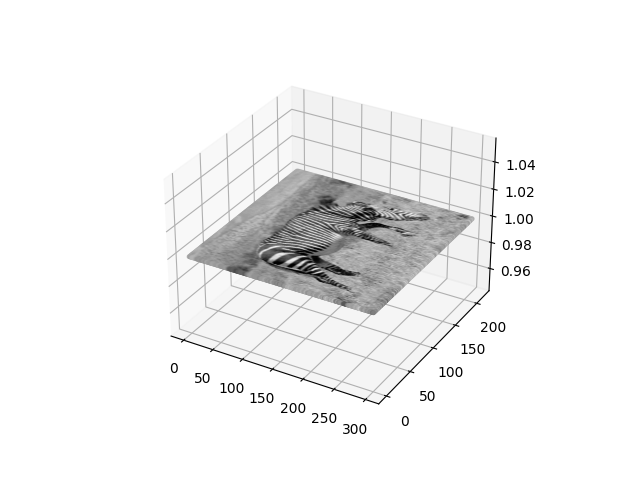

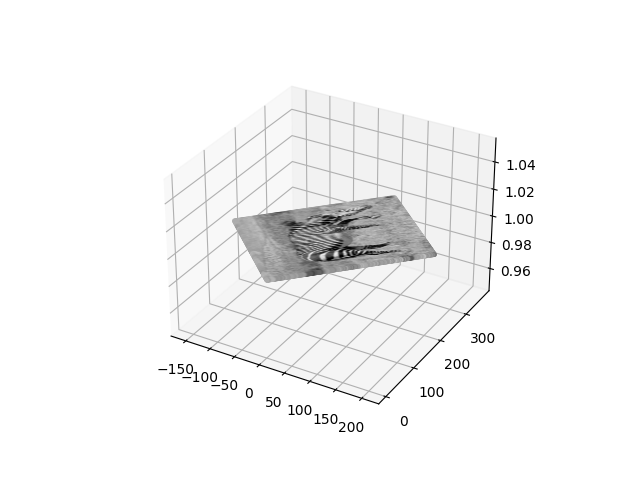

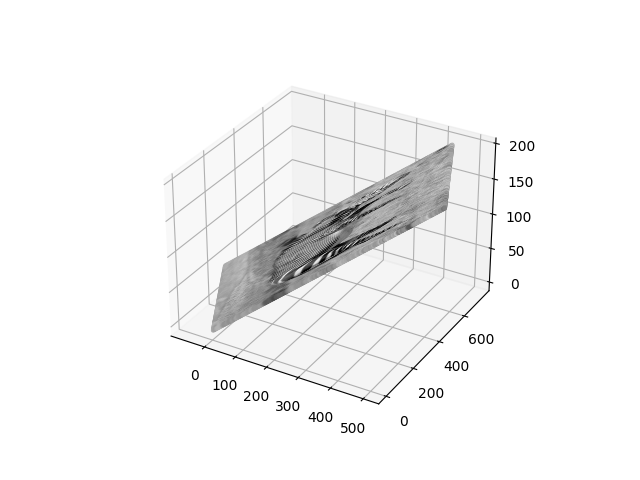

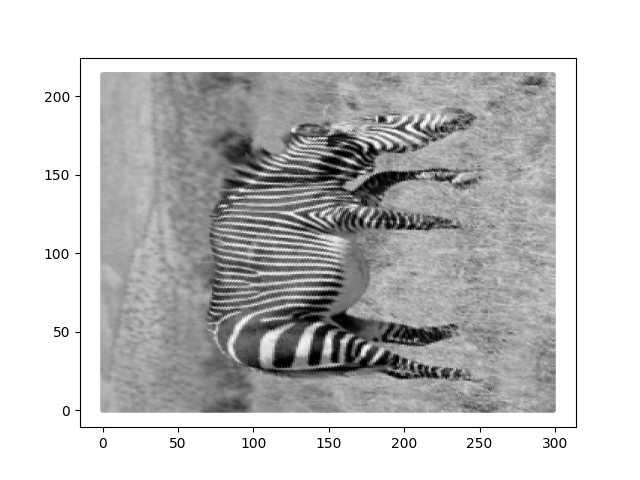

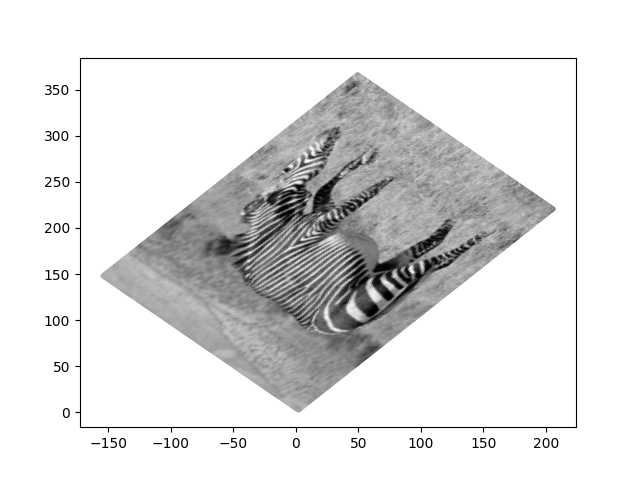

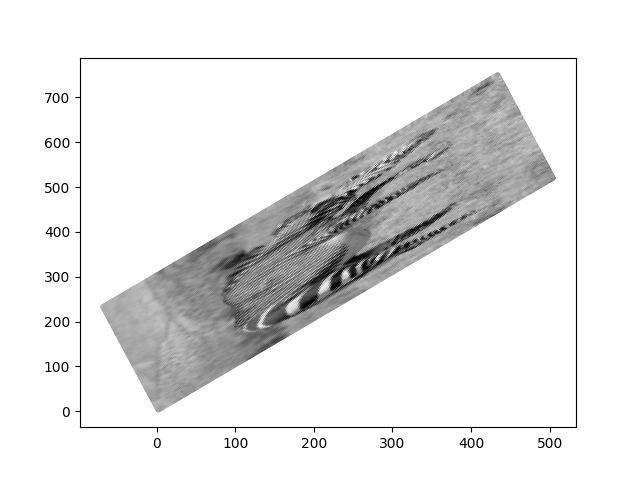

In [85]:
# Import zebra image
zebra_img = cv2.imread('images/Zebra_small.png') # load our source image
zebra_img = cv2.cvtColor(zebra_img, cv2.COLOR_BGR2GRAY) # convert to grayscale
resize_factor = 1.0
zebra_img = cv2.resize(zebra_img, (int(zebra_img.shape[0]*resize_factor), int(zebra_img.shape[1]*resize_factor)))

# Make the image of homogenous coordinates
zebra_img_homog_coord = get_homogenous_img_coordinates(zebra_img)

# Create x and y coordinate matrices
affine_transformation = create_affine_transformation()
homography = create_homography_transformation()

zebra_img_affine_transformation = apply_transformation(zebra_img_homog_coord, affine_transformation)
zebra_img_homography = apply_transformation(zebra_img_homog_coord, homography)

plot_image_3D(zebra_img_homog_coord, zebra_img)
plot_image_3D(zebra_img_affine_transformation, zebra_img)
plot_image_3D(zebra_img_homography, zebra_img)

plot_image_2D(zebra_img_homog_coord, zebra_img)
plot_image_2D(zebra_img_affine_transformation, zebra_img)
plot_image_2D(zebra_img_homography, zebra_img)


2D gradient

X shape:  (100, 100)
Y shape:  (100, 100)
combined data shape:  (100, 100)
color:  (100, 100, 4)
x_new.shape:  (10000,)
color_new.shape:  (10000, 4)


C:\Users\Joshua\AppData\Local\Temp\ipykernel_96044\3872947505.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(x_new, y_new, c=color_new, cmap=custom_cmap, s=50, marker='o')


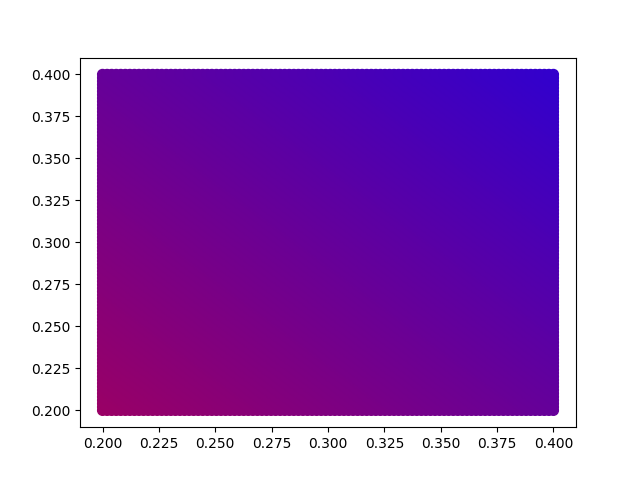

In [86]:
# Code Adatped from AI

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
lowest_color_value = 0.2
highest_color_value = 0.8
x = np.linspace(lowest_color_value, highest_color_value/num_dimensions, 100)
y = np.linspace(lowest_color_value, highest_color_value/num_dimensions, 100)
X, Y = np.meshgrid(x, y)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

# Combine data for both dimensions into a single variable
combined_data = X + Y  # You can use a different combination as needed
print("combined data shape: ", combined_data.shape)
# print(combined_data)
# combined_data = normalize(combined_data, norm='l2', axis=0)
# print(combined_data)
# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)
# color = np.delete(color, -1, axis=-1)
print("color: ", color.shape)
# print(color)
# Create a figure and axis
fig, ax = plt.subplots()

# reshape x and y to match what is expected
x_new = X.reshape((-1,))
y_new = Y.reshape((-1,))
color_new = color.reshape((-1, 4))
print("x_new.shape: ", x_new.shape)
print("color_new.shape: ", color_new.shape)

# Plot the 2D grid with the colormap representing both dimensions
sc = ax.scatter(x_new, y_new, c=color_new, cmap=custom_cmap, s=50, marker='o')
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label('Color Gradient')

# Show the plot
plt.show()

3D gradient


In [87]:
# Define coordinate vectors (1D arrays)
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30])

# Use np.meshgrid to create coordinate matrices
X, Y = np.meshgrid(x, y)
print("X (Coordinate Matrix for X):")
print(X)
print("Y (Coordinate Matrix for Y):")
print(Y)

X (Coordinate Matrix for X):
[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
Y (Coordinate Matrix for Y):
[[10 10 10 10]
 [20 20 20 20]
 [30 30 30 30]]


#### Homography Explained With Code ####
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html 

#### Youtube Video Explaining Homography ####

- 2x2 Image Transformations: https://youtu.be/K2XLXlyPqCA 

- 3x3 Image Transformations: https://www.youtube.com/watch?v=B8kMB6Hv2eI

- Homography: https://www.youtube.com/watch?v=l_qjO4cM74o 